# Multiple trials

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport algebra
%aimport util
%aimport inference
%aimport link
%aimport graph
%precision 4

'%.4f'

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, inference, graph
from algebra import ichol_gauss, subspace

In [3]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
mpl.rcParams['axes.color_cycle'] = ['348ABD', '7A68A6', 'A60628', '467821', 'CF4457', '188487', 'E24A33']
mpl.rcParams['figure.figsize'] = (10, 6)

In [4]:
# dimensions
ntrial = 16
ntime = 1000
nspike = 50
nlatent = 3

## Generate latent

### Lorenz attractor

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


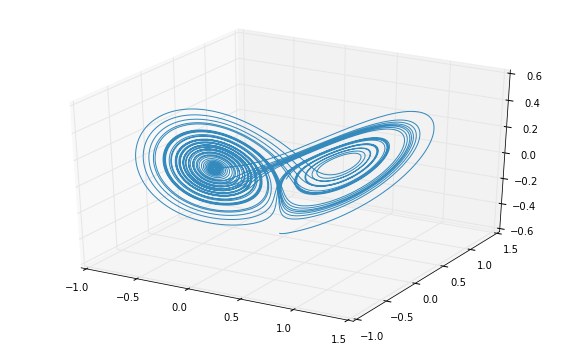

In [9]:
lorenz = simulation.lorenz(1000 + ntrial * ntime, dt=3e-3, x0=np.random.random(3))
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(lorenz[:, 0], lorenz[:, 1], lorenz[:, 2]);

In [11]:
x = lorenz[1000:, :].reshape((ntrial, ntime, -1))
for m in range(ntrial):
    x[m, :] = (x[m, :] - x[m, :].mean(axis=0)) / norm(x[m, :], axis=0, ord=np.inf)

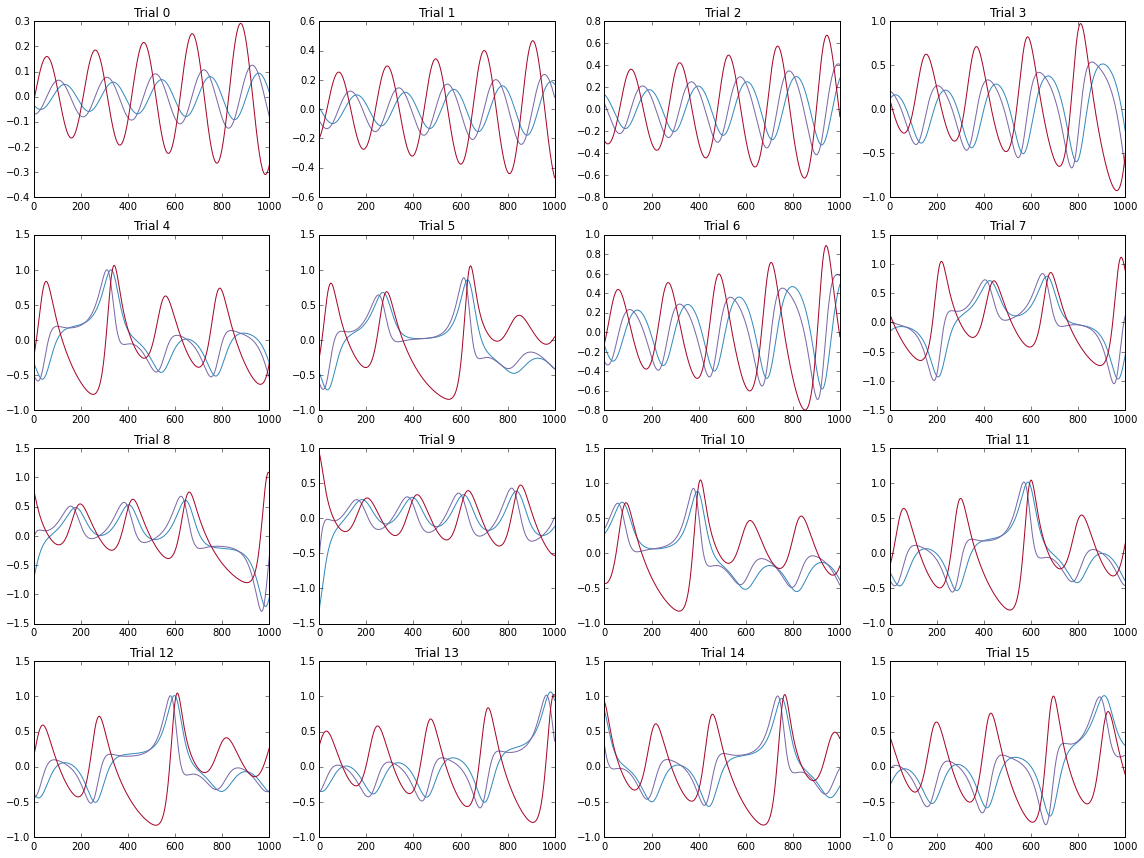

In [12]:
graph.dynplot(x, figsize=(4, 3))

Simulate spike trains

In [13]:
np.random.seed(0)
low = np.log(20 / ntime)
aspk = 0.3 + (np.random.random((nlatent, nspike)) - 0.5) * 1.2
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike)))

In [14]:
y, _, _ = simulation.spike(x, aspk, bspk)

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


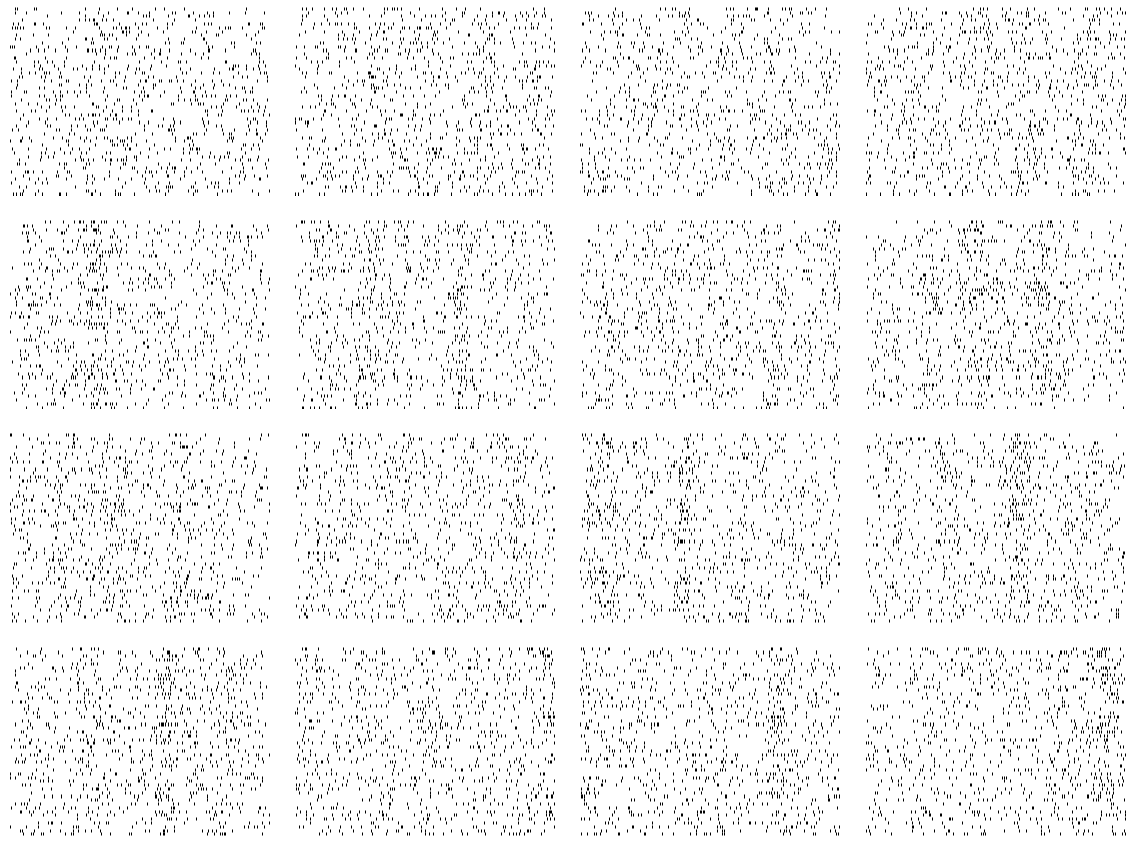

In [15]:
graph.rasterplot(y, ncol=4, figsize=(4, 3));

In [16]:
sample_lorenz1 = {'y': y, 'x': x, 'a': aspk, 'b':bspk}
savemat('data/sample_lorenz1', sample_lorenz1)

In [17]:
sigma = np.full(nlatent, fill_value=1.0)
omega = np.full(nlatent, fill_value=1e-3)

In [38]:
result = inference.multitrials(y[:15, :, :], None, sigma, omega, x=x[:15, :, :], ta=aspk, tb=bspk, lag=0, rank=100, tol=1e-6)

Inference starting
Iteration[1], posterior elapsed: 1.71, parameter elapsed: 1.70, total elapsed: 4.20, ELBO: -323454.0751
Iteration[2], posterior elapsed: 1.56, parameter elapsed: 1.64, total elapsed: 3.96, ELBO: -161433.0732
Iteration[3], posterior elapsed: 1.59, parameter elapsed: 1.63, total elapsed: 3.97, ELBO: -109769.1078
Iteration[4], posterior elapsed: 1.57, parameter elapsed: 1.68, total elapsed: 4.00, ELBO: -96588.1013
Iteration[5], posterior elapsed: 1.59, parameter elapsed: 1.66, total elapsed: 3.99, ELBO: -94602.2845
Iteration[6], posterior elapsed: 1.58, parameter elapsed: 1.65, total elapsed: 3.98, ELBO: -94469.6492
Iteration[7], posterior elapsed: 1.58, parameter elapsed: 1.65, total elapsed: 3.97, ELBO: -94458.2236
Iteration[8], posterior elapsed: 1.57, parameter elapsed: 1.66, total elapsed: 3.98, ELBO: -94454.2351
Iteration[9], posterior elapsed: 1.57, parameter elapsed: 1.65, total elapsed: 3.99, ELBO: -94451.7489
Iteration[10], posterior elapsed: 1.66, parameter e

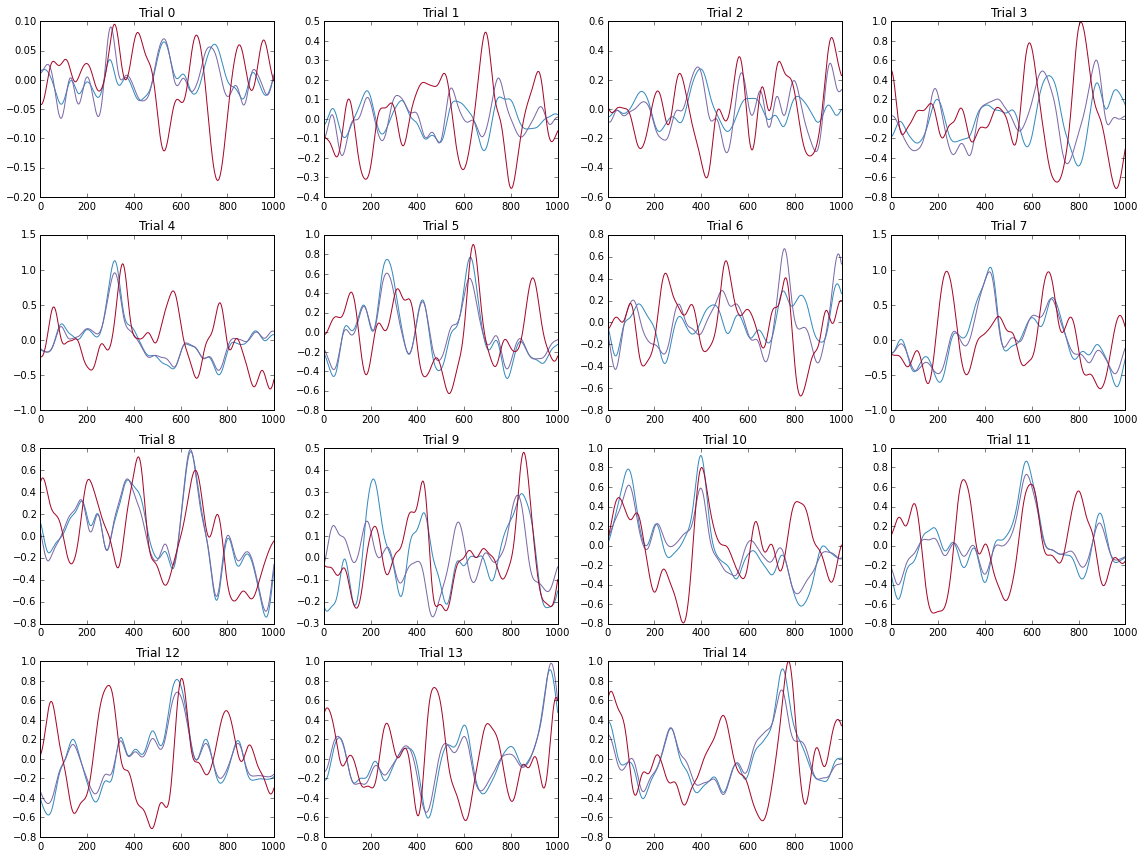

In [39]:
rotated = np.empty_like(result['posterior']['mu'])
for m in range(ntrial - 1):
    rotated[m, :] = util.rotate(result['posterior']['mu'][m, :], x[m, :])
graph.dynplot(rotated, figsize=(4, 3))

In [40]:
result['stat']

{'ELBO': array([-40048626.1962,   -323454.0751,   -161433.0732,   -109769.1078,
           -96588.1013,    -94602.2845,    -94469.6492,    -94458.2236,
           -94454.2351,    -94451.7489,    -94450.4056,    -94449.5868,
           -94449.0698,    -94448.7378,    -94448.5409,    -94448.3911,
           -94448.2744,    -94448.1954]),
 'elapsed': array([[ 0.    ,  0.    ,  0.    ],
        [ 1.7111,  1.702 ,  4.2048],
        [ 1.5613,  1.6417,  3.9573],
        [ 1.5937,  1.6292,  3.9656],
        [ 1.5727,  1.6755,  4.0034],
        [ 1.5895,  1.6578,  3.9933],
        [ 1.5761,  1.6519,  3.9786],
        [ 1.5807,  1.6473,  3.9719],
        [ 1.5734,  1.6576,  3.9826],
        [ 1.5691,  1.6528,  3.9883],
        [ 1.6626,  1.8209,  4.3276],
        [ 1.7026,  2.1168,  4.6375],
        [ 1.7318,  1.9492,  4.5277],
        [ 1.5967,  1.6887,  4.0417],
        [ 1.6029,  1.6803,  4.0544],
        [ 1.6125,  1.8723,  4.2601],
        [ 1.613 ,  1.7944,  4.1883],
        [ 1.6184,  1.7

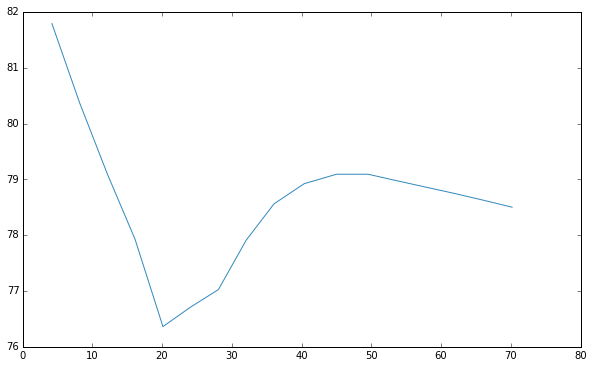

In [41]:
plot(np.cumsum(result['stat']['elapsed'][1:,2]), result['stat']['loadingangle'][1:] * 180 / np.pi);

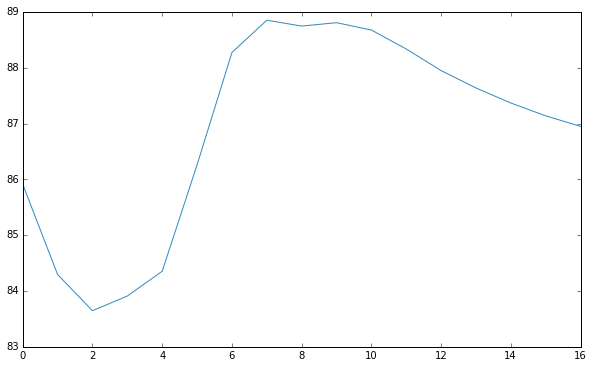

In [42]:
plot(result['stat']['latentangle'][1:] * 180 / np.pi);